In [62]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
import pyspark.sql.functions as psf
import json


In [2]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [15]:
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [6]:
conf = SparkConf().setMaster("local[*]").setAppName("Pipeline")
sc = SparkContext(conf=conf)

23/02/20 04:20:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [8]:
spark = SparkSession(sc)

In [10]:
data = spark.read.csv('./predictions.csv',header=True,inferSchema=True)
data.head()

Row(pnns_groups_1='unknown', energy-kcal_100g=262.0, energy_100g=1096.0, fat_100g=5.95, saturated-fat_100g=1.19, carbohydrates_100g=66.67, sugars_100g=2.38, proteins_100g=16.67, salt_100g=0.0254, sodium_100g=0.01016, features='[262.0,1096.0,5.95,1.19,66.67,2.38,16.67,0.0254,0.01016]', scaled='[1.2244022416191034,1.221596966594334,0.33185536610089694,0.12775740095740562,2.0120978340997655,0.12620272315593636,1.4036102016282366,0.0009370690717162629,0.0009370609642839143]', prediction=1)

In [11]:
data.printSchema()

root
 |-- pnns_groups_1: string (nullable = true)
 |-- energy-kcal_100g: double (nullable = true)
 |-- energy_100g: double (nullable = true)
 |-- fat_100g: double (nullable = true)
 |-- saturated-fat_100g: double (nullable = true)
 |-- carbohydrates_100g: double (nullable = true)
 |-- sugars_100g: double (nullable = true)
 |-- proteins_100g: double (nullable = true)
 |-- salt_100g: double (nullable = true)
 |-- sodium_100g: double (nullable = true)
 |-- features: string (nullable = true)
 |-- scaled: string (nullable = true)
 |-- prediction: integer (nullable = true)



In [24]:
columns_to_drop = ['features', 'scaled']
data = data.drop(*columns_to_drop)

In [25]:
features = ['energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

### Assembler

In [28]:
assemble = VectorAssembler(inputCols=features, outputCol='features')
assembled_data = assemble.setHandleInvalid("skip").transform(data)
assembled_data.show(5)

+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+----------+--------------------+
| pnns_groups_1|energy-kcal_100g|energy_100g|       fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|  proteins_100g|      salt_100g|     sodium_100g|prediction|            features|
+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+----------+--------------------+
|       unknown|           262.0|     1096.0|           5.95|              1.19|             66.67|       2.38|          16.67|         0.0254|         0.01016|         1|[262.0,1096.0,5.9...|
|       unknown|             1.0|        4.0|            1.0|               1.0|               1.0|        1.0|            1.0|            1.0|             0.4|         8|[1.0,4.0,1.0,1.0,...|
|       unknown|           277.0|  

### Scaler

In [29]:
from pyspark.ml.feature import StandardScaler

scale=StandardScaler(inputCol='features',outputCol='scaled')
scaled=scale.fit(assembled_data)
data_scaled=scaled.transform(assembled_data)
data_scaled.show(5)

+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+----------+--------------------+--------------------+
| pnns_groups_1|energy-kcal_100g|energy_100g|       fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|  proteins_100g|      salt_100g|     sodium_100g|prediction|            features|              scaled|
+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+----------+--------------------+--------------------+
|       unknown|           262.0|     1096.0|           5.95|              1.19|             66.67|       2.38|          16.67|         0.0254|         0.01016|         1|[262.0,1096.0,5.9...|[1.22440224161910...|
|       unknown|             1.0|        4.0|            1.0|               1.0|               1.0|        1.0|            1.0|            1.0| 

In [49]:
cols = ["scaled", "prediction"]
scaled_data = data_scaled.select(*cols)
scaled_data.show()

+--------------------+----------+
|              scaled|prediction|
+--------------------+----------+
|[1.22440224161910...|         1|
|[0.00467329099854...|         8|
|[1.29450160659729...|         0|
|[3.07035218604484...|         7|
|[2.33664549927309...|        10|
|[0.59818124781391...|         8|
|[3.25261053498814...|        10|
|[2.33664549927309...|        10|
|[0.12150556596220...|         8|
|[1.31786806159002...|         1|
|[1.90670272740684...|         4|
|[0.78511288775575...|         0|
|[0.29909062390695...|         8|
|[0.78043959675721...|         0|
|[0.75707314176448...|         0|
|(9,[0,1,2,3],[3.8...|         7|
|[0.47667568185171...|         8|
|[0.00918301681214...|         8|
|[1.23374882361619...|         0|
|[0.79913276075139...|         0|
+--------------------+----------+
only showing top 20 rows



In [131]:
scaled_data1 = scaled_data.withColumnRenamed("prediction","claster_pred")

### Train test split

In [163]:
train_df, test_df = scaled_data1.randomSplit(weights = [0.70, 0.30], seed = 42)

### Linear Regression

In [52]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'scaled', labelCol='claster_pred', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.20661328494098719,-0.9337943226826309,0.4809977959575168,-0.9812505620845295,0.0,0.0]
Intercept: 5.620065216775463


In [88]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 3.391814
r2: 0.162539


In [54]:
# сравним rmse со средним значением 
train_df.describe().show()

+-------+------------------+
|summary|      claster_pred|
+-------+------------------+
|  count|             63186|
|   mean| 4.511964675719305|
| stddev|3.7064080598262974|
|    min|                 0|
|    max|                10|
+-------+------------------+



In [94]:
lr_test = lr.fit(test_df)

In [95]:
print("Coefficients: " + str(lr_test.coefficients))
print("Intercept: " + str(lr_test.intercept))

Coefficients: [-0.16536874395307402,-0.2884764828704084,0.0,0.6537064057109185,0.0,0.21076927648701324,-0.32996206870761613,0.0,0.0]
Intercept: 4.858754927541659


In [96]:
trainingSummary_test = lr_test.summary
print("RMSE: %f" % trainingSummary_test.rootMeanSquaredError)
print("r2: %f" % trainingSummary_test.r2)

RMSE: 3.545943
r2: 0.088153


### Random Forest

In [98]:
RandomForest = RandomForestClassifier(labelCol="claster_pred", featuresCol="scaled",
                        predictionCol='rand_prediction', numTrees=20, maxDepth=3)

In [100]:
model_rand = RandomForest.fit(train_df)

In [102]:
predictions_rand = model_rand.transform(test_df)

In [118]:
# Select (prediction, true label) and compute test error
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="claster_pred", predictionCol="rand_prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rand)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.135688


In [110]:
evaluator_pr = MulticlassClassificationEvaluator(
    labelCol="claster_pred", predictionCol="rand_prediction", metricName="precision")
precision = evaluator.evaluate(predictions_rand)
print(f"Precision = {precision} ")

Precision = 0.8643117153257559 


In [151]:
train_df.show()

+---------+------------+
|   scaled|claster_pred|
+---------+------------+
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
|(9,[],[])|           8|
+---------+------------+
only showing top 20 rows



### Logistic Regression

In [154]:
log_reg = LogisticRegression(featuresCol = 'scaled', labelCol = 'claster_pred', maxIter=10)
lrModel = log_reg.fit(train_df)

### Metrics

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Силуэтные оценки для разного количества кластеров
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,15):
    
    KMeans_algo=KMeans(featuresCol='scaled', k=i)
    
    KMeans_fit=KMeans_algo.fit(scaled_data)
    
    output=KMeans_fit.transform(scaled_data)
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print(f"Clusters: {i}, Silhouette Score: {score}")

Text(0, 0.5, 'cost')

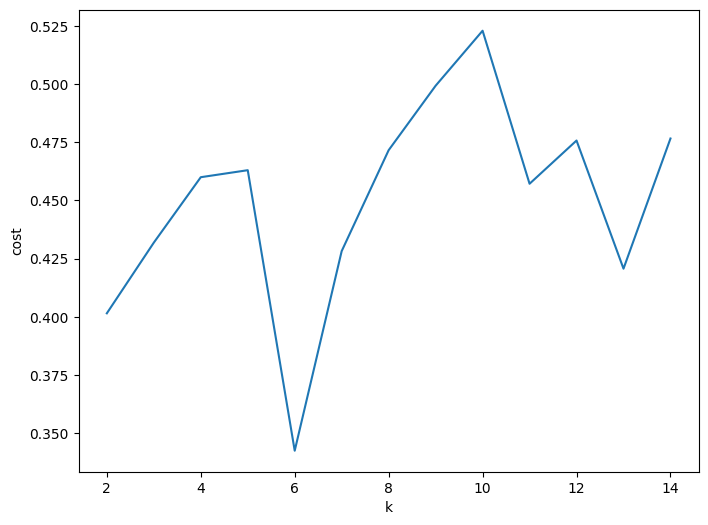

In [60]:
# Для кластеризации находим оптимальное число кластеров

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

### Pipeline

In [140]:
pipeline = Pipeline(stages=[assemble, scale, lr, RandomForest,LogReg])

pipelineModel = pipeline.fit(scaled_data)
model = pipelineModel.transform(test_df)

In [142]:
model

DataFrame[scaled: vector, claster_pred: int, rawPrediction: vector, probability: vector, prediction: double]